<h1 align = "center">TPS May 2022</h1>

---


**Objective:** The May edition of the 2022 Tabular Playground series binary classification problem that includes a number of different feature interactions. This competition is an opportunity to explore various methods for identifying and exploiting these feature interactions ([competition](https://www.kaggle.com/competitions/tabular-playground-series-may-2022/overview)). This notebook serves to provide codes that I've used for solving TPS May 2022. My initial plan is to use a powerful *neural network* to do a binary classification for *predicting states of manufacturing control data*.

## Code Imports

**PEP8 Style Guide** lists out the following [*guidelines*](https://peps.python.org/pep-0008/#imports) for imports:
 1. Imports should be on separate lines,
 2. Import order should be:
    * standard library/modules,
    * related third party imports,
    * local application/user defined imports
 3. Wildcard import (`*`) should be avoided, else specifically tagged with **`# noqa: F403`** as per `flake8` [(ignoring errors)](https://flake8.pycqa.org/en/3.1.1/user/ignoring-errors.html).
 4. Avoid using relative imports; use explicit imports instead.

In [1]:
import sys # append additional directories to list
import warnings # display specified user warnings as required

In [2]:
from time import ctime # print computer time in human redable format
from os import makedirs # create directories dynamically
from os.path import join # joins mutiple path without os dependency
# from copy import deepcopy # make an actual copy of immutable objects like `str`
# from tqdm import tqdm as TQ # for displaying a nice progress bar while running
# from uuid import uuid1 as UUID # for generating unique identifier
from datetime import datetime as dt # formatting/defining datetime objects

[**`logging`**](https://docs.python.org/3/howto/logging.html) is a standard python module that is meant for tracking any events that happen during any software/code operations. This module is super powerful and helpful for code debugging and other purposes. The next section defines a `logging` configuration in **`../logs/`** directory. Modify the **`LOGS_DIR`** variable under *Global Arguments* to change the default directory. The module is configured with a simplistic approach, such that any `print())` statement can be update to `logging.LEVEL_NAME()` and the code will work. Use logging operations like:

```python
 >> logging.debug("This is a Debug Message.")
 >> logging.info("This is a Information Message.")
 >> logging.warning("This is a Warning Message.")
 >> logging.error("This is a ERROR Message.")
 >> logging.critical("This is a CRITICAL Message.")
```

Note: some directories related to logging is created by default. This can be updated/changed in the following configuration section.

In [3]:
import logging # configure logging on `global arguments` section, as file path is required

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%precision 3
%matplotlib inline
sns.set_style('whitegrid');
plt.style.use('default-style');
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 35)
np.set_printoptions(precision = 3, threshold = 15)
pd.options.display.float_format = '{:,.2f}'.format

### AI-ML Libraries

In this project, to build a neural network, I am using the **`TensorFlow`** module with GPU Compatibility. **Note:** Not able to load GPU capability in Jupyter Notebooks, but works through terminal (system issue)!

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [6]:
import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")

# check physical devices
tf.config.list_physical_devices()

Tensorflow Version: 2.8.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Global Argument(s)

The global arguments are *notebook* specific, however they may also be extended to external libraries and functions on import. The *boilerplate* provides a basic ML directory structure which contains a directory for `data` and a separate directory for `output`. In addition, a separate directory (`data/processed`) is created to save processed dataset such that preprocessing can be avoided.

In [7]:
ROOT = ".." # the document root is one level up, that contains all code structure
DATA = join(ROOT, "data") # the directory contains all data files, subdirectory (if any) can also be used/defined

# processed data directory can be used, such that preprocessing steps is not
# required to run again-and-again each time on kernel restart
PROCESSED_DATA = join(DATA, "processed")

In [8]:
# long projects can be overwhelming, and keeping track of files, outputs and
# saved models can be intriguing! to help this out, `today` can be used. for
# instance output can be stored at `output/<today>/` etc.
# `today` is so configured that it permits windows/*.nix file/directory names
today = dt.strftime(dt.strptime(ctime(), "%a %b %d %H:%M:%S %Y"), "%a, %b %d %Y")
print(f"Code Execution Started on: {today}") # only date, name of the sub-directory

Code Execution Started on: Mon, May 16 2022


In [9]:
OUTPUT_DIR = join(ROOT, "output", today)
makedirs(OUTPUT_DIR, exist_ok = True) # create dir if not exist

# also create directory for `logs`
LOGS_DIR = join(ROOT, "logs", "TPS May 2022")
makedirs(LOGS_DIR, exist_ok = True)

In [10]:
print(LOGS_DIR) # logs file will be generated here

..\logs\TPS May 2022


In [11]:
logging.captureWarnings(True) # send warnings to log file automatically https://stackoverflow.com/a/37979724/6623589
logging.basicConfig(
    filename = join(LOGS_DIR, f"{today}.log"), # change `reports` file name
    filemode = "a", # append logs to existing file, if file exists
    format = "%(asctime)s - %(name)s - CLASS:%(levelname)s:%(levelno)s:L#%(lineno)d - %(message)s",
    level = logging.DEBUG
)

In [12]:
logging.info("Initializing Kernel, Global Arguments Configured....")
logging.info(f"Data Directory: {DATA}")
logging.info(f"Output Data Directory: {OUTPUT_DIR}")

In [13]:
logging.info(f"Tensorflow Version: {tf.__version__}")

NUM_GPUs = len(tf.config.list_physical_devices('GPU'))
logging.info(f"Num GPUs Available: {NUM_GPUs}")
if NUM_GPUs == 0:
    warnings.warn("Using TF in CPU Only Mode. Is GPU Configured?")

## User Defined Function(s)

It is recommended that any UDFs are defined outside the scope of the *jupyter notebook* such that development/editing of function can be done more practically. As per *programming guidelines* as [`src`](https://fileinfo.com/extension/src) file/directory is beneficial in code development and/or production release. However, *jupyter notebook* requires *kernel restart* if any imported code file is changed in disc, for this frequently changing functions can be defined in this section.

**Getting Started** with **`PYTHONPATH`**

One must know what are [Environment Variable](https://medium.com/chingu/an-introduction-to-environment-variables-and-how-to-use-them-f602f66d15fa) and how to call/use them in your choice of programming language. Note that an environment variable is *case sensitive* in all operating systems (except windows, since DOS is not case sensitive). Generally, we can access environment variables from terminal/shell/command prompt as:

```shell
# macOS/*nix
echo $VARNAME

# windows
echo %VARNAME%
```

Once you've setup your system with [`PYTHONPATH`](https://bic-berkeley.github.io/psych-214-fall-2016/using_pythonpath.html) as per [*python documentation*](https://docs.python.org/3/using/cmdline.html#envvar-PYTHONPATH) is an important directory where any `import` statements looks for based on their order of importance. If a source code/module is not available check necessary environment variables and/or ask the administrator for the source files.

For testing purpose, the module boasts the use of `src`, `utils` and `config` directories. However, these directories are available at `ROOT` level, and thus using `sys.path.append()` to add directories while importing.

In [14]:
sys.path.append(join(ROOT, "src")) # source files
sys.path.append(join(ROOT, "src", "agents")) # agents for an efficient rl model
sys.path.append(join(ROOT, "src", "engine")) # ai/ml code engines for modelling
sys.path.append(join(ROOT, "src", "models")) # defination of actual ai/ml model
sys.path.append(join(ROOT, "utilities")) # provide a list of utility functions

In [15]:
from dfutils import reduce_mem_usage
from visualizations import corr_heatmap

In [16]:
def read_file(filepaths : str, **kwargs) -> pd.DataFrame:
    trn = pd.read_csv(filepaths[0]) # read training data csv file as is
    tst = pd.read_csv(filepaths[1]) # read training data csv file as is
    
    # since the data set has different values in categorical variables,
    # thus, the data is first concatenated - to perform the following ops:
    #  1. `one_hot_encode` : `cat_cols` which was identified previously
    #  2. `perform_encode` : on `f_27` using `LabelEncoder()`
    trn["isTrain"] = True
    tst["isTrain"] = False
    
    data = pd.concat([trn, tst], ignore_index = True) # index is later replaced
    # do some pre-processing on the data-frame
    data.set_index("id", inplace = True) # set index
    
    # get keyword arguments, and do operations
    drop_feature = kwargs.get("drop_feature", False)
    reduce_memory = kwargs.get("reduce_memory", True)
    one_hot_encode = kwargs.get("one_hot_encode", True)
    perform_encode = kwargs.get("perform_encode", True)
    add_stats_feat = kwargs.get("add_stats_feat", False)
    
    if perform_encode:
        encoder = LabelEncoder()
        data["f_27_enc"] = encoder.fit_transform(data["f_27"])
    
    if drop_feature:
        # remove `f_27` column from data set
        data.drop(columns = ["f_27"], inplace = True) # drop object feature
        
    if one_hot_encode:
        # apply one hot encoding on the dataset
        # using the inbuilt `pd.get_dummies` method
        # also drop the categorical columns which were previously identified
        cat_cols = [
            'f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13',
            'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_29', 'f_30'
        ]
        
        data = pd.get_dummies(data, columns = cat_cols, drop_first = True)
        # data.drop(columns = cat_cols, inplace = True)
        
    if reduce_memory:
        # perform data type casting to reduce memory usage
        # check documentation for more information on the method
        data = reduce_mem_usage(data, subset = None, copy = False)
        
    if add_stats_feat:
        num_cols = [
            'f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_19',
            'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_28'
        ]
        data["f_min"] = data[num_cols].min(axis = 1)
        data["f_max"] = data[num_cols].max(axis = 1)
        data["f_sum"] = data[num_cols].sum(axis = 1)
        data["f_std"] = data[num_cols].std(axis = 1)
        data["f_mad"] = data[num_cols].mad(axis = 1)
        data["f_mean"] = data[num_cols].mean(axis = 1)
        data["f_kurt"] = data[num_cols].kurt(axis = 1)
        
    # now seperate the training and testing dataset
    # and return a deep copy version of the data frame
    trn_trf = data[data["isTrain"]]
    tst_trf = data[~data["isTrain"]]
    
    trn_trf.drop(columns = ["isTrain"], inplace = True)
    tst_trf.drop(columns = ["isTrain", "target"], inplace = True)
    
    return trn_trf.copy(), tst_trf.copy()

## Read Input File(s)

A typical machine learning project revolves around six important stages (as available in [Amazon ML Life Cycle Documentation](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/well-architected-machine-learning-lifecycle.html)). The notebook boilerplate is provided to address two pillars:

 1. **Data Processing:** An integral part of any machine learning project, which is the most time consuming step! A brief introduction and best practices is available [here](https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d).
 2. **Model Development:** From understanding to deployment, this section address development (training, validating and testing) of an machine learning model.

![ML Life Cycle](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/images/ml-lifecycle.png)

In [17]:
# trn_data, tst_data = read_file(filepaths = [join(DATA, "train.csv"), join(DATA, "test.csv")], drop_feature = True, reduce_memory = False, add_stats_feat = True)
trn_data, tst_data = read_file(filepaths = [join(DATA, "train.csv"), join(DATA, "test.csv")], drop_feature = True, reduce_memory = False, add_stats_feat = False, one_hot_encode = False, perform_encode = False)

In [18]:
trn_data.sample()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
798870,0.23,-0.13,0.10,0.36,0.62,-1.15,-0.64,7,0,0,2,1,2,3,0,2,1,1,0,-0.60,-0.38,-2.58,-2.29,-4.93,1.61,0.20,1.82,87.38,1,1,0.00


In [19]:
# cat_cols = trn_data.drop(columns = "target").nunique().where(lambda x : x <= 16).dropna().index.tolist() # maybe do featuring
cat_cols = [
    'f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13',
    'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_29', 'f_30'
]

print(cat_cols) # list of previously identified categorical variables

['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_29', 'f_30']


In [20]:
num_cols = ['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_19','f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_28']
print(num_cols)

['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_28']


### Basic Data Information

Training and testing data is read into two variables `trn_data` and `tst_data` respectively. Let's use the basic `pandas` functionalities to find information about the data. The target is a binary column and marked as `target`, and the data has a total of 31 features marked as `f_00, f_01, ..., f_30`. Apart from this, let's display some statistical information for analysis.

 * There are a total of 0.9 million records in training data, and testing is to be performed on 0.7 million records (a fair ratio).
 * There are no `NaN` values (can be verified using `trn_data.isnull().sum().sum()`).
 * The target is binary i.e. either `0` or `1`, generally a `sigmoid` activation should be okay? Let's check this while the model is developed.
 
Below, we can use the `value_counts` method to quickly check the distribution of target variable.

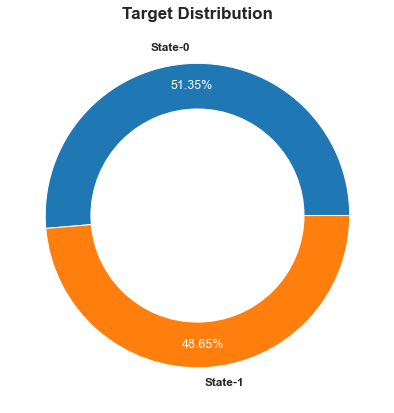

In [32]:
target_distribution = trn_data["target"].value_counts(normalize = True)

graph_labels = [f"State-{idx}" for idx in  target_distribution.index]

fig, axs = plt.subplots()
_, _, autopct = plt.pie(target_distribution, labels = graph_labels, autopct = lambda v : f"{v:.2f}%", pctdistance = 0.85, textprops = {"weight" : "bold"}) # plot a pie chart
plt.setp(autopct, **{"color" : "white", "weight" : "regular", "fontsize" : 12.5})

circle = plt.Circle((0, 0), 0.7, color = "white")
plt.gcf().gca().add_artist(circle)

plt.title("Target Distribution")
plt.show()

The target variable is evenly distributed (i.e. around 50% of data is present in each state).

In [21]:
trn_data.sample(5)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
317060,-0.46,-1.15,-0.85,-0.33,-0.64,1.39,-1.07,3,0,2,1,1,4,1,4,0,3,1,2,-2.25,3.50,-8.55,1.45,-2.68,-1.00,1.17,-0.09,BABEAACMAB,-71.49,1,1,0
188147,-0.29,-0.48,-2.44,-1.78,-1.44,0.93,0.74,2,5,4,0,3,3,0,2,1,2,2,2,1.61,1.72,-2.27,2.52,-1.91,2.02,-1.20,-0.66,BDBADADICF,-151.33,0,2,0
644769,0.51,-0.98,-1.93,1.60,0.43,1.22,0.04,2,2,1,5,4,4,3,1,4,2,3,1,1.01,-1.88,-0.72,-3.43,2.09,-0.40,-3.80,0.81,BDBDABEFBE,47.71,0,0,1
407494,0.06,-0.52,0.51,0.30,0.37,-0.81,0.69,1,1,2,2,2,2,0,3,3,2,0,1,-1.83,-0.36,-3.03,-0.29,-1.44,0.16,-0.86,0.29,ADBDAADDCD,-54.02,0,0,0
582457,-2.11,-0.82,1.48,-0.37,-0.66,-0.82,0.65,1,1,2,4,5,4,1,2,0,4,2,2,-0.68,0.57,-3.97,-2.11,-2.91,-0.75,-0.13,3.11,BCBCBBBPBA,84.01,1,0,0


In [38]:
trn_data.shape

(900000, 32)

In [34]:
trn_data.describe(percentiles = [0.05, 0.25, 0.50, 0.75, 0.95])

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
count,"900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00"
mean,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,2.03,2.06,2.36,2.18,1.80,2.84,2.24,1.51,2.10,2.10,1.86,2.07,0.31,-0.18,-0.16,-0.01,-0.37,-0.34,0.18,0.36,-0.38,0.35,1.00,0.49
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.66,1.59,1.64,1.65,1.54,1.76,1.54,1.36,1.57,1.56,1.47,1.56,2.32,2.40,2.48,2.45,2.45,2.39,2.42,2.48,238.77,0.48,0.82,0.50
min,-4.60,-4.68,-4.64,-4.66,-4.75,-4.75,-4.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-11.28,-11.26,-13.31,-11.85,-12.30,-11.42,-11.92,-14.30,"-1,229.75",0.00,0.00,0.00
5%,-1.64,-1.64,-1.65,-1.65,-1.64,-1.64,-1.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.53,-4.11,-4.24,-4.11,-4.36,-4.26,-3.77,-3.78,-392.09,0.00,0.00,0.00
25%,-0.68,-0.68,-0.67,-0.68,-0.68,-0.67,-0.67,1.00,1.00,1.00,1.00,1.00,2.00,1.00,0.00,1.00,1.00,1.00,1.00,-1.24,-1.80,-1.82,-1.65,-2.02,-1.96,-1.44,-1.26,-159.43,0.00,0.00,0.00
50%,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,2.00,2.00,2.00,2.00,2.00,3.00,2.00,1.00,2.00,2.00,2.00,2.00,0.33,-0.19,-0.15,0.03,-0.39,-0.34,0.16,0.40,-0.52,0.00,1.00,0.00
75%,0.67,0.68,0.68,0.67,0.67,0.68,0.67,3.00,3.00,3.00,3.00,3.00,4.00,3.00,2.00,3.00,3.00,3.00,3.00,1.88,1.44,1.51,1.66,1.26,1.27,1.80,2.03,158.99,1.00,2.00,1.00
95%,1.64,1.65,1.65,1.64,1.65,1.65,1.65,5.00,5.00,5.00,5.00,5.00,6.00,5.00,4.00,5.00,5.00,5.00,5.00,4.08,3.78,3.91,3.95,3.71,3.58,4.16,4.34,392.65,1.00,2.00,1.00
max,4.75,4.82,4.96,4.45,4.95,4.97,4.82,15.00,16.00,14.00,14.00,13.00,16.00,12.00,14.00,14.00,15.00,14.00,13.00,12.08,11.48,14.46,11.34,12.25,12.39,12.53,12.91,"1,229.56",1.00,2.00,1.00


### Correlation \& Feature Engineering

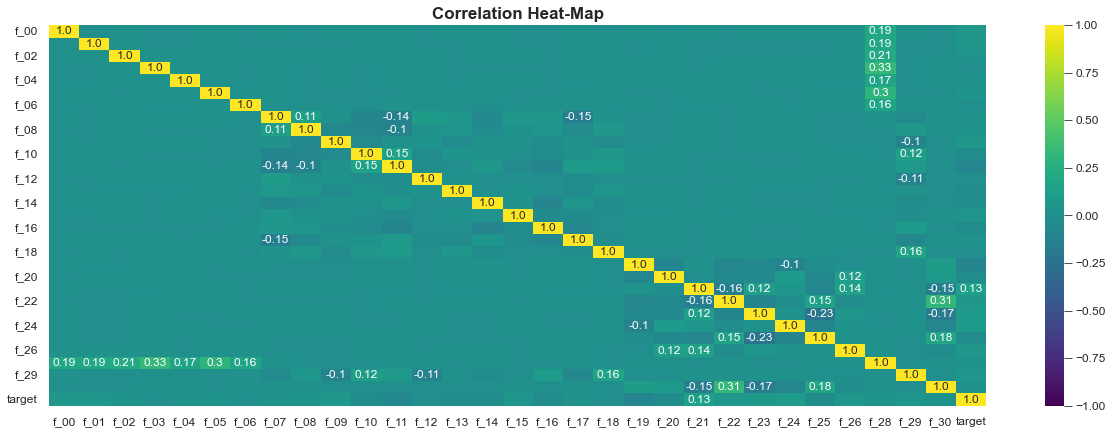

In [46]:
corr_heatmap(trn_data, annot_threshold = 0.1)

plt.title("Correlation Heat-Map")
plt.show()

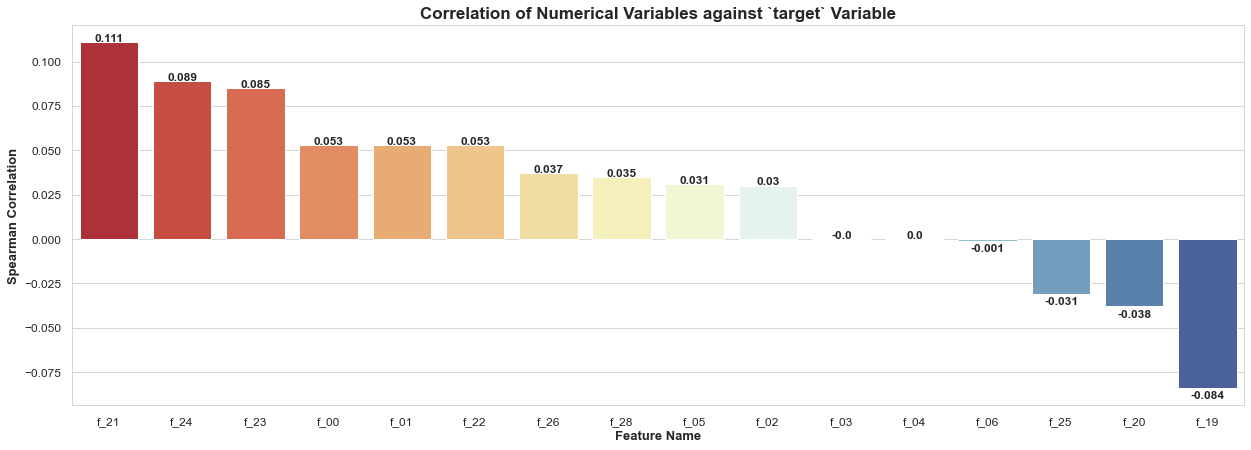

In [54]:
# no value has much correlation
# let's check the individual values against target
corr = trn_data[num_cols + ["target"]].corr(method = "spearman").round(3)

# get correlation of all features against target variable
corr = corr.iloc[:-1, -1].sort_values(ascending = False).reset_index()

axs = sns.barplot(x = "index", y = "target", data = corr, palette = sns.color_palette("RdYlBu", len(num_cols)).as_hex())

# show corr value on graph
corr_ = corr["target"].values
for tick in range(len(axs.get_xticklabels())):
    y_pos = corr_[tick] + 5e-4 if corr_[tick] >= 0 else corr_[tick] - 6e-3
    axs.text(tick, y_pos, str(corr_[tick]), ha = "center", weight = "bold")
    
axs.set(xlabel = "Feature Name")
axs.set(ylabel = "Spearman Correlation")

plt.title("Correlation of Numerical Variables against `target` Variable")
plt.show()

From correlation heat map, it is evident that there is no column which shares a strong relation with the target variable. In this type of cases, feature engineering may improve the prediction results significantly. Thus, let's perform the following feature engineering.

#### Categorical Variable \& One-Hot Encoding

Let's first check the number of unique values for each given features (excluding *target variable*). Also from the data sample we know that `f_27` is already a *categorical variable*, however we can see that the number of unique count is high (so some special attention for this column).

In [48]:
trn_data.drop(columns = "target").nunique().sort_values(ascending = True) # check unique value count

f_29         2
f_30         3
f_13        13
f_18        14
f_17        14
f_14        14
f_11        14
f_10        15
f_09        15
f_15        15
f_07        16
f_12        16
f_16        16
f_08        16
f_27    741354
f_28    900000
f_26    900000
f_25    900000
f_24    900000
f_23    900000
f_22    900000
f_20    900000
f_19    900000
f_01    900000
f_02    900000
f_03    900000
f_04    900000
f_05    900000
f_06    900000
f_21    900000
f_00    900000
dtype: int64

Let's check the data of only the identified categorical data. For this, using the `np.where` functionality to filter the column names.

In [50]:
trn_data[cat_cols].sample(5)

,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_29,f_30
id,,,,,,,,,,,,,,
874189,1,1,3,7,5,3,1,0,2,0,1,1,1,2
496397,1,0,0,2,1,0,3,3,1,3,3,1,1,1
238913,0,4,4,0,1,2,2,1,3,1,3,1,0,1
86127,2,1,0,3,4,3,3,0,1,3,0,2,1,0
565713,3,4,4,4,2,3,2,1,5,1,4,2,1,2


In [55]:
# let's check the unique values
{col : sorted(trn_data[col].unique().tolist()) for col in cat_cols}

{'f_07': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'f_08': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16],
 'f_09': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'f_10': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'f_11': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'f_12': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16],
 'f_13': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'f_14': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14],
 'f_15': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'f_16': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'f_17': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14],
 'f_18': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'f_29': [0, 1],
 'f_30': [0, 1, 2]}

In [105]:
# let's check the unique values
{col : sorted(tst_data[col].unique().tolist()) for col in cat_cols}

{'f_07': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16],
 'f_08': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'f_09': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16],
 'f_10': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'f_11': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'f_12': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'f_13': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'f_14': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'f_15': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14],
 'f_16': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'f_17': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'f_18': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'f_29': [0, 1],
 'f_30': [0, 1, 2]}

Thus, considering the above detected variables, implementing the *one hot encoding* method in the `read_file` method, to make our life easy! Also, the original columns are deleted, as they are not required.

In [33]:
trn_data.sample(5)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,target,...,f_17_14,f_18_1,f_18_2,f_18_3,f_18_4,f_18_5,f_18_6,f_18_7,f_18_8,f_18_9,f_18_10,f_18_11,f_18_12,f_18_13,f_29_1,f_30_1,f_30_2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
203867,-1.10,-1.31,0.56,-0.21,1.85,0.18,0.02,0.34,-1.28,-1.01,-1.38,0.91,1.66,0.32,2.33,87.62,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
369825,-0.88,-1.29,1.76,-1.79,0.28,0.21,-0.93,0.98,-0.53,1.86,-3.69,2.70,1.73,-1.35,0.31,-488.50,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
379045,0.69,0.94,0.73,-1.18,-0.45,0.70,-1.35,-7.12,-1.25,-2.66,3.51,1.03,4.48,4.53,-3.38,-167.12,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
274848,-0.19,-0.94,0.34,-2.16,0.85,1.37,0.60,1.03,5.20,0.91,0.17,3.10,-3.01,-2.61,-1.37,-50.91,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
725608,0.08,-1.43,-0.03,1.70,-0.87,-0.14,0.79,1.90,-0.03,-0.81,1.05,-0.82,0.04,-0.76,0.28,186.25,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


#### EDA on Numerical Variables

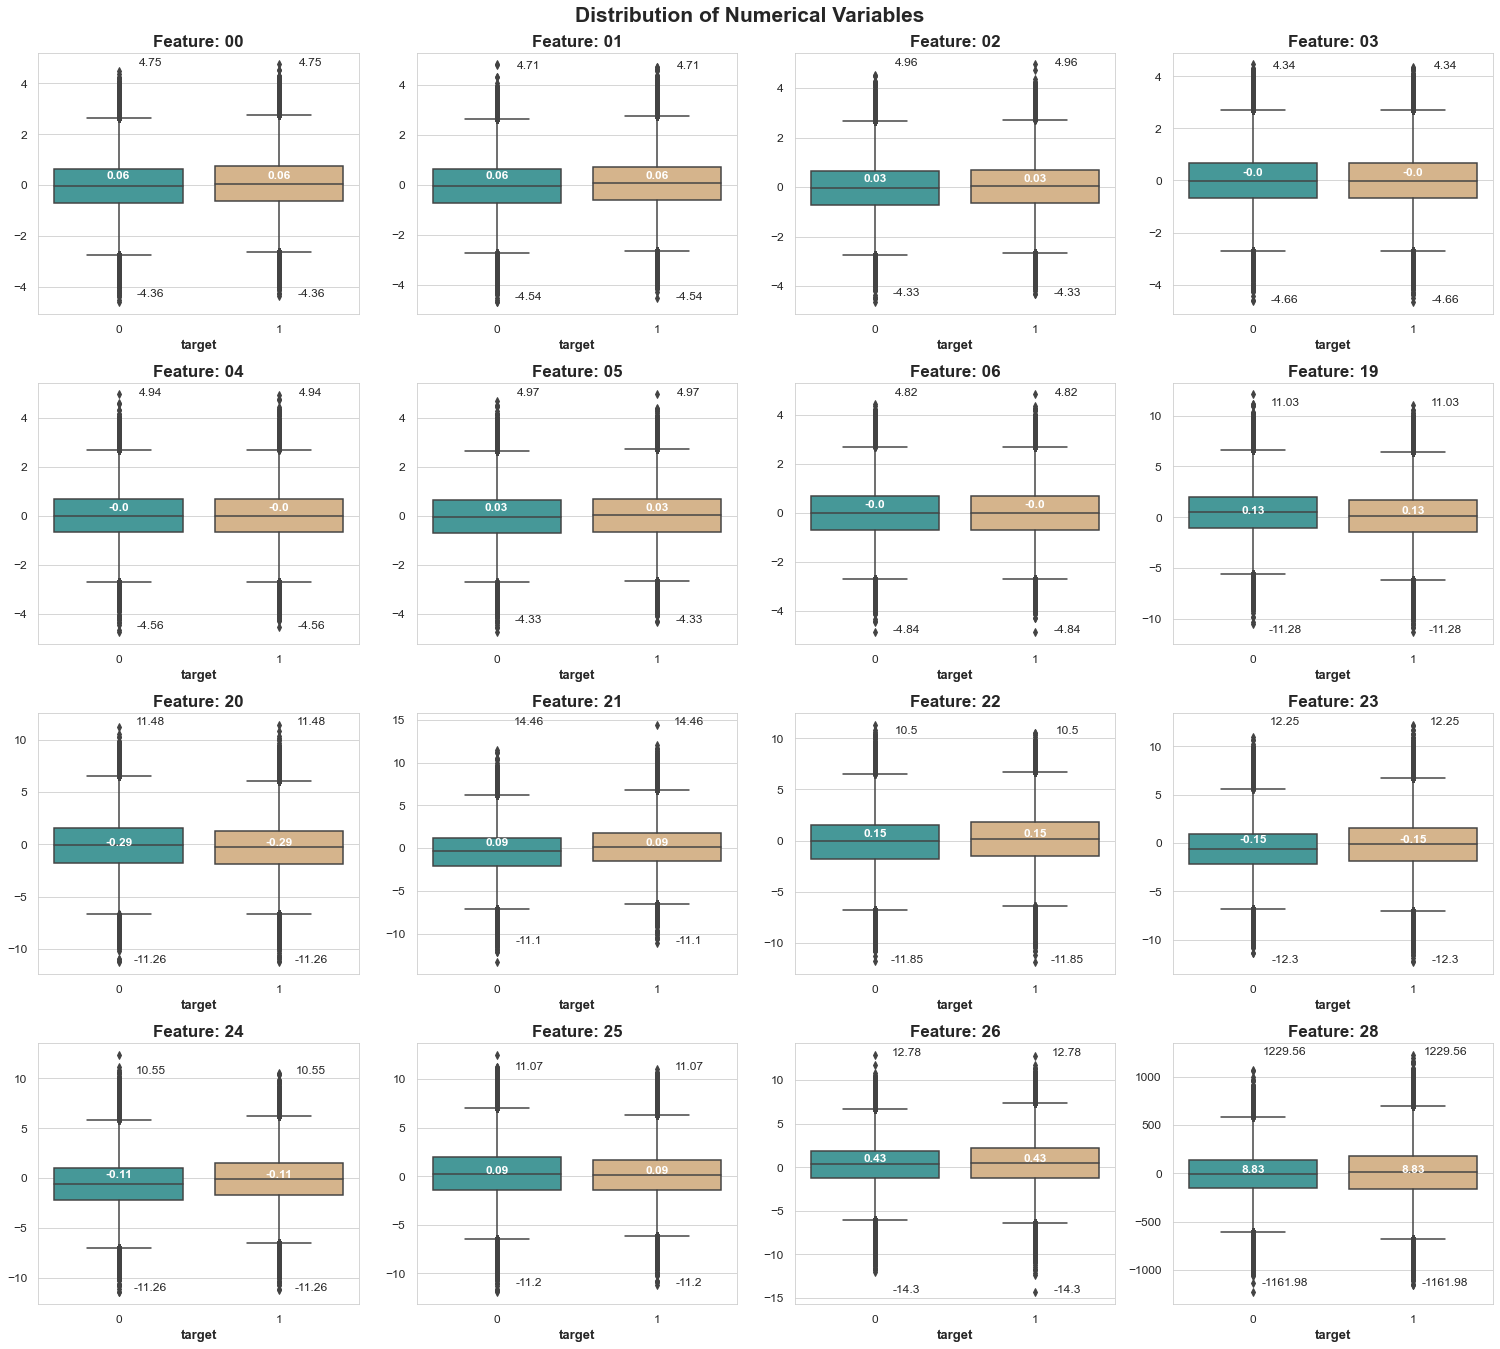

In [101]:
fig, axs = plt.subplots(4, 4, figsize = (21, 24))

grouped = trn_data.groupby("target").agg(["median", "min", "max"])
axs = axs.ravel() # https://stackoverflow.com/a/17211410/6623589
for idx, col in enumerate(num_cols):
    # sns.boxplot with axs https://stackoverflow.com/a/41384984/6623589
    g = sns.boxplot(x = "target", y = col, data = trn_data, palette = ["#38A6A5", "#E1B580"], ax = axs[idx])
    
    # https://stackoverflow.com/a/58476779/6623589
    g.set(title = "Feature: " + col.split("_")[1])
    g.set(ylabel = None)
    
    # also display statistican values in boxplot
    mins = np.round(grouped[col, "min"].values, 2)
    maxs = np.round(grouped[col, "max"].values, 2)
    medians = np.round(grouped[col, "median"].values, 2)
    
    ind = 0
    for tick in range(len(g.get_xticklabels())):
        # adding min and max values
        g.text(tick + 0.2, mins[ind + 1] - 0.05, str(mins[ind + 1]), ha = "center")
        g.text(tick + 0.2, maxs[ind + 1] - 0.05, str(maxs[ind + 1]), ha = "center")
        
        # adding median value
        # https://stackoverflow.com/a/45476485/6623589
        g.text(tick, medians[ind + 1] + 0.2, str(medians[ind + 1]), ha = "center", color = "white", weight = "semibold")
    
plt.suptitle("Distribution of Numerical Variables")
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
plt.show()

## Deep Learning Application

### Data Scaling

In [21]:
# training data
x_train = trn_data.drop(columns = "target").values
y_train = trn_data["target"].values

# testing data
x_test = tst_data.values

In [22]:
scalar = StandardScaler()

x_train_sc = scalar.fit_transform(x_train)
x_test_sc = scalar.transform(x_test)

### Base Model

In [23]:
x_train.shape, y_train.shape, x_test.shape

((900000, 30), (900000,), (700000, 30))

In [24]:
INPUT_SHAPE = x_train.shape[1]
OUTPUT_SHAPE = len(set(y_train))

INPUT_SHAPE, OUTPUT_SHAPE

(30, 2)

In [50]:
# nural network parameters
ACTIVATION_FUNCTION = "swish"
L2_KERNEL_REGULARIZER = tf.keras.regularizers.l2(5e-7)

# model tuning parameters
LR_START = 1e-2
LR_FINAL = 2e-4
NUM_EPOCHS = 100
BATCH_SIZE = 4096

LR_FUNC = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.7, patience = 4)
ES_FUNC = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 12, mode = "min", restore_best_weights = True)
TM_FUNC = tf.keras.callbacks.TerminateOnNaN()

# define the callbacks for model
callbacks = [
    LR_FUNC, # learning rate
    ES_FUNC, # early stopping of model training
    TM_FUNC  # terminate model training on null value
]

Generally, the optimal number of neurons in first hidden layer is proposed by the formula:

$$
  N_h = a (N_i + N_o)
$$

where, $N_h$ is the number of neurons in hidden layer, and $N_i$ and $N_o$ are the number of neurons in input and output layer respectively; and $a \in [2, 10]$ is an arbitrary scaling factor.

In [42]:
Nh = 2 * (INPUT_SHAPE + OUTPUT_SHAPE)
print(f"Proposed Optimal Number of Neurons on 1st Hidden Layer = {Nh}")

Proposed Optimal Number of Neurons on 1st Hidden Layer = 64


In [62]:
model = tf.keras.Sequential([
    ### INPUT LAYER ###
    tf.keras.layers.Dense(
        Nh,
        input_shape = (INPUT_SHAPE, ),
        activation = ACTIVATION_FUNCTION,
        kernel_regularizer = L2_KERNEL_REGULARIZER,
        name = "iLayer", 
    ),
    
    tf.keras.layers.BatchNormalization(name = "iBN"),
    # tf.keras.layers.Dropout(0.2, name = "iD"),
    
    ### Hidden Layers ###
    tf.keras.layers.Dense(
        256,
        activation = ACTIVATION_FUNCTION,
        kernel_regularizer = L2_KERNEL_REGULARIZER,
        name = "HL1", 
    ),
    
    tf.keras.layers.BatchNormalization(name = "BN1"),
    tf.keras.layers.Dropout(0.4, name = "D1"),
    
    tf.keras.layers.Dense(
        256,
        activation = ACTIVATION_FUNCTION,
        kernel_regularizer = L2_KERNEL_REGULARIZER,
        name = "HL2", 
    ),
    
    tf.keras.layers.BatchNormalization(name = "BN2"),
    tf.keras.layers.Dropout(0.2, name = "D2"),
    
    tf.keras.layers.Dense(
        128,
        activation = ACTIVATION_FUNCTION,
        kernel_regularizer = L2_KERNEL_REGULARIZER,
        name = "HL3", 
    ),
    
    tf.keras.layers.BatchNormalization(name = "BN3"),
    tf.keras.layers.Dropout(0.2, name = "D3"),
    
    tf.keras.layers.Dense(
        64,
        activation = ACTIVATION_FUNCTION,
        kernel_regularizer = L2_KERNEL_REGULARIZER,
        name = "HL4", 
    ),
    
    tf.keras.layers.BatchNormalization(name = "BN4"),
    tf.keras.layers.Dropout(0.2, name = "D4"),
    
    tf.keras.layers.Dense(
        32,
        activation = ACTIVATION_FUNCTION,
        kernel_regularizer = L2_KERNEL_REGULARIZER,
        name = "HL5", 
    ),
    
    tf.keras.layers.BatchNormalization(name = "BN5"),
    tf.keras.layers.Dropout(0.2, name = "D5"),
    
    tf.keras.layers.Dense(
        64, # 16,
        activation = ACTIVATION_FUNCTION,
        kernel_regularizer = L2_KERNEL_REGULARIZER,
        name = "HL6", 
    ),
    
    tf.keras.layers.BatchNormalization(name = "BN6"),
    tf.keras.layers.Dropout(0.1, name = "D6"),
    
    ### OUTPUT Layer ###
    tf.keras.layers.Dense(
        16,
        activation = ACTIVATION_FUNCTION,
        name = "oLayer_R1", 
    ),
    
    tf.keras.layers.Dense(
        8,
        activation = ACTIVATION_FUNCTION,
        name = "oLayer_R2", 
    ),
    
    tf.keras.layers.BatchNormalization(name = "final"),
    
    tf.keras.layers.Dense(
        1,
        activation = "sigmoid", # binarry data
        name = "oLayer", 
    )
], name = "DFC-1.3.6")

# model.summary(line_length = 127)

In [63]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LR_START, amsgrad = True),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryCrossentropy()],
)

In [64]:
ctime_ = dt.strftime(dt.strptime(ctime(), "%a %b %d %H:%M:%S %Y"), "%a, %b %d %Y (%H%M%S)") # time at which model training is started
print(f"Model Training Started at : {ctime_}")
history = model.fit(x_train, y_train, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE, validation_split = 0.3, shuffle = True)

Model Training Started at : Mon, May 16 2022 (171212)
Epoch 1/100
154/154 [==============================] - 7s 30ms/step - loss: 0.5981 - binary_crossentropy: 0.5974 - val_loss: 0.6014 - val_binary_crossentropy: 0.6007
Epoch 2/100
154/154 [==============================] - 4s 28ms/step - loss: 0.4958 - binary_crossentropy: 0.4950 - val_loss: 0.5140 - val_binary_crossentropy: 0.5131
Epoch 3/100
154/154 [==============================] - 4s 28ms/step - loss: 0.4558 - binary_crossentropy: 0.4549 - val_loss: 0.4920 - val_binary_crossentropy: 0.4909
Epoch 4/100
154/154 [==============================] - 4s 29ms/step - loss: 0.4068 - binary_crossentropy: 0.4056 - val_loss: 0.3879 - val_binary_crossentropy: 0.3865
Epoch 5/100
154/154 [==============================] - 4s 29ms/step - loss: 0.3740 - binary_crossentropy: 0.3725 - val_loss: 0.3746 - val_binary_crossentropy: 0.3728
Epoch 6/100
154/154 [==============================] - 4s 27ms/step - loss: 0.3535 - binary_crossentropy: 0.3515 - v

Epoch 50/100
154/154 [==============================] - 4s 27ms/step - loss: 0.2958 - binary_crossentropy: 0.2886 - val_loss: 0.2840 - val_binary_crossentropy: 0.2768
Epoch 51/100
154/154 [==============================] - 4s 28ms/step - loss: 0.2960 - binary_crossentropy: 0.2888 - val_loss: 0.2810 - val_binary_crossentropy: 0.2738
Epoch 52/100
154/154 [==============================] - 4s 28ms/step - loss: 0.2958 - binary_crossentropy: 0.2885 - val_loss: 0.2901 - val_binary_crossentropy: 0.2828
Epoch 53/100
154/154 [==============================] - 4s 28ms/step - loss: 0.2961 - binary_crossentropy: 0.2887 - val_loss: 0.2837 - val_binary_crossentropy: 0.2764
Epoch 54/100
154/154 [==============================] - 4s 28ms/step - loss: 0.2958 - binary_crossentropy: 0.2885 - val_loss: 0.2828 - val_binary_crossentropy: 0.2754
Epoch 55/100
154/154 [==============================] - 4s 28ms/step - loss: 0.2949 - binary_crossentropy: 0.2875 - val_loss: 0.2858 - val_binary_crossentropy: 0.278

154/154 [==============================] - 4s 28ms/step - loss: 0.2907 - binary_crossentropy: 0.2824 - val_loss: 0.2836 - val_binary_crossentropy: 0.2753
Epoch 100/100
154/154 [==============================] - 4s 28ms/step - loss: 0.2901 - binary_crossentropy: 0.2818 - val_loss: 0.2798 - val_binary_crossentropy: 0.2715


#### Model Performance

Check the performance of the model using the `history` and plot different curves.

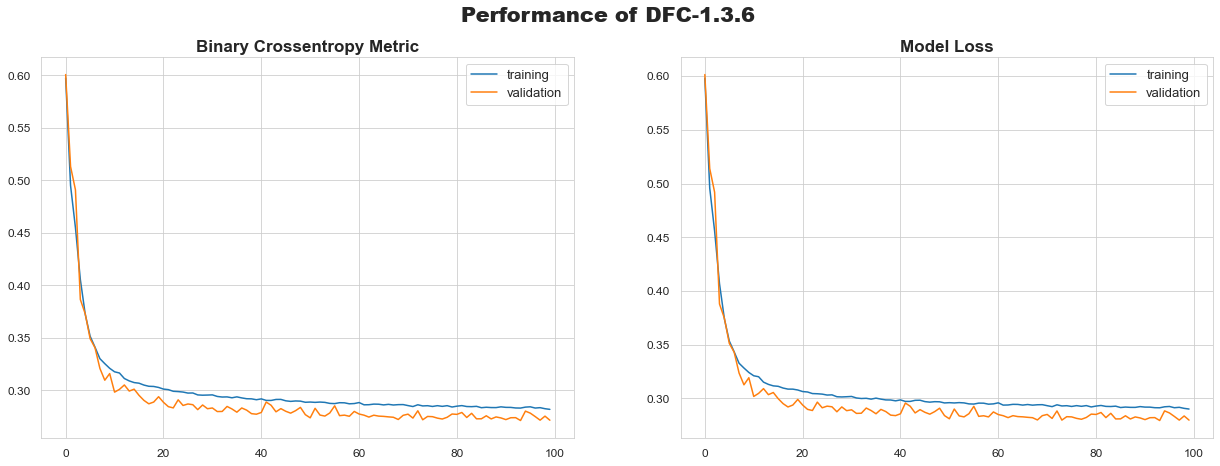

In [65]:
# plot model accuracy
plt.subplot(121)
plt.plot(history.history["binary_crossentropy"], label = "training")
plt.plot(history.history["val_binary_crossentropy"], label = "validation")

plt.title("Binary Crossentropy Metric")
plt.legend(loc = "upper right")

plt.subplot(122)
plt.plot(history.history["loss"], label = "training")
plt.plot(history.history["val_loss"], label = "validation")

plt.title("Model Loss")
plt.legend(loc = "upper right")

plt.suptitle(f"Performance of {model.name}")
plt.savefig(join(OUTPUT_DIR, f"{model.name} - {ctime_}.png"))
plt.show()

In [66]:
yPredicted = model.predict(x_test)

In [67]:
yPredicted

array([[0.923],
       [0.943],
       [0.007],
       ...,
       [0.095],
       [0.073],
       [0.001]], dtype=float32)

In [68]:
# output = pd.DataFrame({"id" : tst_data.index, "target" : np.argmax(yPredicted, axis = 1)})
# output.sample()

In [69]:
output = pd.DataFrame({"id" : tst_data.index, "target" : yPredicted.reshape(1, -1)[0]})
output["target"] = output["target"].apply(lambda x : 0 if x <= 0.5135 else 1) # since target = 0 in `input` is about 51.35%

output.sample()

,id,target
207718,1107718,0


In [70]:
output.to_csv(join(OUTPUT_DIR, f"{model.name} - {ctime_}.csv"), index = False)